# Gensim, Mallet, TF-IDF

In [5]:
!pip install nltk

In [6]:
!pip install spacy

In [7]:
!pip  install pyLDAvis

  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97715 sha256=2316723a644a5ff774db44ce1dc4dd49442d0f2c7d2b83863b2873c5f1496f4f
  Stored in directory: C:\Users\M\AppData\Local\pip\Cache\wheels\98\71\24\513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [11]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\M\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
!python -m spacy download en

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
[x] Couldn't link model to 'en'
Creating a symlink in spacy/data failed. Make sure you have the required
permissions and try re-running the command as admin, or use a virtualenv. You
can still import the model as a module and call its load() method, or create the
symlink manually.
C:\Users\M\Anaconda3\lib\site-packages\en_core_web_sm -->
C:\Users\M\Anaconda3\lib\site-packages\spacy\data\en
[!] Download successful but linking failed
Creating a shortcut link for 'en' didn't work (maybe you don't have admin
permissions?), but you can still load the model via its full package name: nlp =
spacy.load('en_core_web_sm')


ЌҐ¤®бв в®з­® ЇаЁўЁ«ҐЈЁ© ¤«п ўлЇ®«­Ґ­Ёп нв®© ®ЇҐа жЁЁ.


In [12]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\M\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [13]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [14]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [16]:
# Convert to list
data = df.content.values.tolist()


#YOURCODE

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [17]:
#tikenize

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [19]:
#your code here 
# напишите программу, которая нам руками будет возвращать N-число самых частых биграмм в тексте

#быстро нашёл в инете 0-- е было времени -- вроде работает
bigrams = [b for l in text2 for b in zip(l.split(" ")[:-1], l.split(" ")[1:])]
freq = nltk.FreqDist(bigrams) #computes freq of occurrence
fdist = freq.keys() # sorted according to freq

NameError: name 'text2' is not defined

In [18]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


In [21]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [26]:
!python -m spacy download en_core_web_sm

[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [31]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['where', 'thing', 'car', 'nntp_poste', 'host', 'park', 'line', 'wonder', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'door', 'really', 'small', 'addition', 'separate', 'rest', 'body', 'know', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


In [32]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 5), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1)]]


In [37]:
%%time
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
from gensim.models.wrappers import LdaMallet
os.environ['MALLET_HOME'] = 'D:/mallet-2.0.8/mallet-2.0.8'
mallet_path = 'D:/mallet-2.0.8/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)


# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(2,
  [('key', 0.035380290309625355),
   ('gun', 0.023178871273116717),
   ('encryption', 0.013195892061427834),
   ('government', 0.01306202069268871),
   ('public', 0.012048423186521065),
   ('law', 0.009753485436707529),
   ('security', 0.009543116142974623),
   ('chip', 0.00950486718047773),
   ('system', 0.009390120292987053),
   ('bit', 0.008280900380577176)]),
 (12,
  [('line', 0.08072880556865138),
   ('good', 0.02950719653900552),
   ('buy', 0.02875842369450068),
   ('price', 0.026983554729748466),
   ('sell', 0.023849801713857845),
   ('sale', 0.020771513353115726),
   ('phone', 0.0142544163731662),
   ('interested', 0.013422446545938601),
   ('mail', 0.013366981890790094),
   ('host', 0.012978729304750547)]),
 (13,
  [('car', 0.04101520411828086),
   ('bike', 0.013025260385490242),
   ('ride', 0.011014006943613073),
   ('drive', 0.008954866515024543),
   ('engine', 0.008787262061534778),
   ('turn', 0.00849994014126661),
   ('front', 0.007805578833951873),
   ('speed', 0.00

Создайте функцию или серию функций, через которую будет удобно подобрать оптимальное число групп - 1 балл за нахождение оптимального числа групп, 1 балл - если этобудет не руками, а через функцию

Как вы знаете, gensim считает, что каждый текст содержит несколько топиков, но на следвующем этапе вам будет надо создать функцию, которая будет для каждого текста определять один широкий топик, самый главный.

Мв предлагаем сделать это так: создайте счётчик, и каждый раз, когда в тексте будет встречаться одно из слов, соответсвующих данной теме, добавляйте к счетчику его вес. 2 балла

После того, как у вас получится какое-то количество групп (наборов текстов с общим топиком). Внутри каждой из этих групп посчитайте тф_идф для каждого текста (Т. е. возьмите все тексты с одинаковой темой за ваш корпус и посчитайте для каждого из этих текстов тф_идф). 3 балла

Каждому тексту определите слова с пятью самыми высокими тф_идф и запишите их в таблицу

вывод - excel, csv или pandas таблица с текстом, его широким топиком по дженсиму и 5 тф_идф словами для этого текста - 1 балл

Логичность и красота кода - 1 балл

ещё один бонус балл: описать как работает coherence score (не успели обсудить на паре) на русском - словами

In [44]:
import tqdm

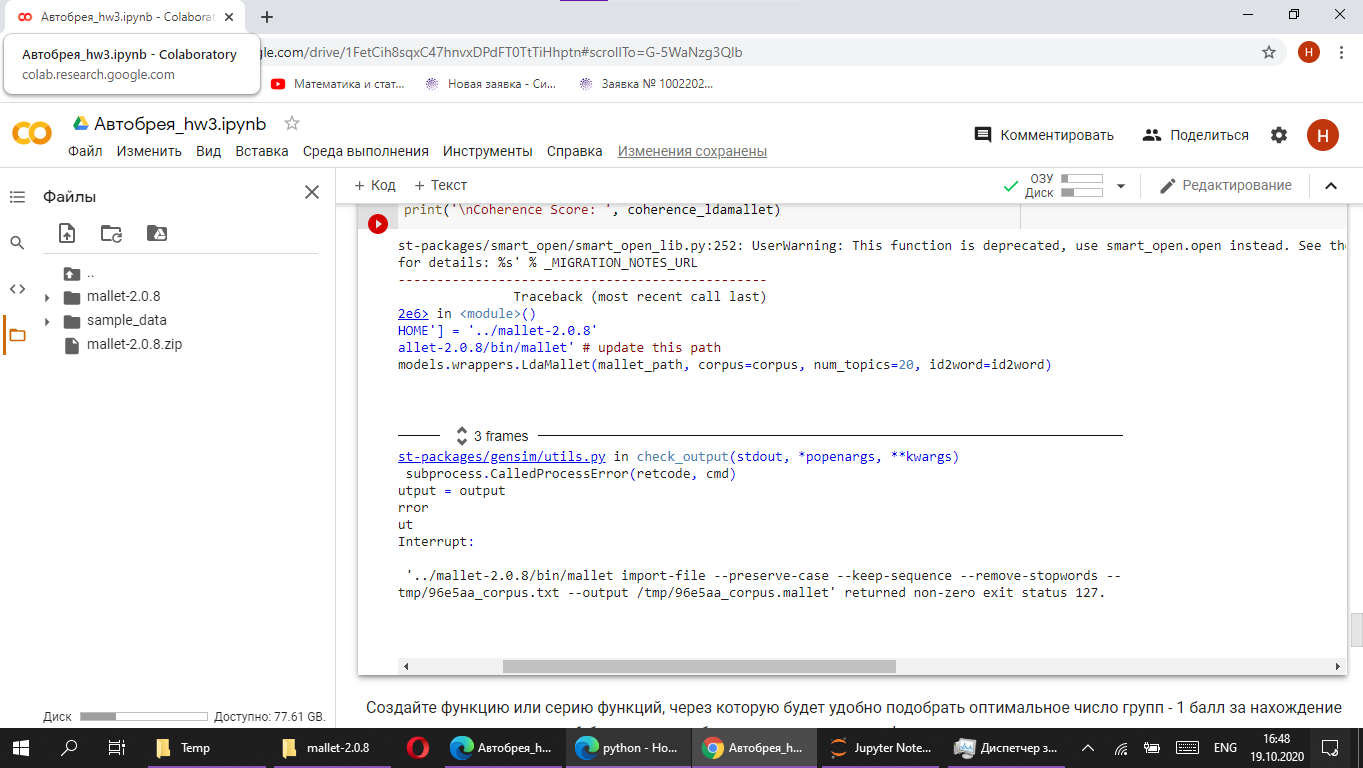

In [ ]:
def choose_score(start, number, rate, corpus, id2word, data_lemmatized):
    os.environ['MALLET_HOME'] = 'D:/mallet-2.0.8/mallet-2.0.8'
    mallet_path = 'D:/mallet-2.0.8/mallet-2.0.8/bin/mallet'
    best_coh = 0
    best_num = 0
    for i in range(start, number, rate):
        print(i)
        ldamallet = tqdm(gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=number, id2word=id2word))
        # Show Topics
        #pprint(ldamallet.show_topics(formatted=False))

        # Compute Coherence Score
        coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_ldamallet = coherence_model_ldamallet.get_coherence()
        #print('\nCoherence Score: ', coherence_ldamallet)
        print(i, coherence_ldamallet)
        if coherence_ldamallet > best_coh:
            best_coh = coherence_ldamallet
            best_num = i
            print('best', best_num, best_coh)
            
    return best_num, best_coh

In [51]:
choose_score(5, 30, 5, corpus, id2word, data_lemmatized)

30


KeyboardInterrupt: 

Как вы знаете, gensim считает, что каждый текст содержит несколько топиков, но на следвующем этапе вам будет надо создать функцию, которая будет для каждого текста определять один широкий топик, самый главный.

Мв предлагаем сделать это так: создайте счётчик, и каждый раз, когда в тексте будет встречаться одно из слов, соответсвующих данной теме, добавляйте к счетчику его вес. 2 балла

После того, как у вас получится какое-то количество групп (наборов текстов с общим топиком). Внутри каждой из этих групп посчитайте тф_идф для каждого текста (Т. е. возьмите все тексты с одинаковой темой за ваш корпус и посчитайте для каждого из этих текстов тф_идф). 3 балла

Каждому тексту определите слова с пятью самыми высокими тф_идф и запишите их в таблицу

вывод - excel, csv или pandas таблица с текстом, его широким топиком по дженсиму и 5 тф_идф словами для этого текста - 1 балл

Логичность и красота кода - 1 балл

ещё один бонус балл: описать как работает coherence score (не успели обсудить на паре) на русском - словами

In [ ]:
all_topics = {}
for i in range(10):
    list_text = []
    dict_of_topic = {}
    df_1 = df_prefinal[df_prefinal['topics'] == i]
    lemmas = df_1['lemmas'].tolist()
    inds = df_1['ind'].tolist()
    for num, t in enumerate(inds):
        dict_of_topic[t] = lemmas[num]
        list_text.append(' '.join(lemmas[num]))
    vectors = vectorizer.fit_transform(list_text)
    feature_names = vectorizer.get_feature_names()
    dense = vectors.todense()
    denselist = dense.tolist()
    df = pd.DataFrame(denselist, columns=feature_names)
    for text in df.index.tolist():
        a = df[df[index] == text]
        

df.columns.tolist()

    all_topics += dict_of_topic

In [ ]:
import pandas as pd

In [ ]:
df = pd.Dataframe()